## Resources & Imports
- Skills: https://github.com/mikeasilva/data-scientist-skills/blob/master/raw_skills.csv
- Skills: https://www.kaggle.com/code/discdiver/the-most-in-demand-skills-for-data-scientists

In [1]:
# database imports
import re as re
import time
import pandas as pd
import os
import numpy as np

# tokenization imports
import spacy

# frequency counter imports
from collections import Counter
import math

# import function to save different files to csv (ie, skills lists)
import csv
import datetime
import json

In [2]:
df = pd.read_csv('output/linkedin_jobs_uncleaned_full_2022-09-01.csv')

# EDA

In [3]:
df

,title,company,location,remote,post_date,num_applicants,contract_type,company_size,description,salary
0,Data Scientist,Nordstrom,"Seattle, WA",On-site,NaN,NaN,level,"10,001+ employees · Retail",About the job\n \n\n \nJob Descriptio...,Full-time · Entry
1,Digital Sales Manager,VP MUSIC GROUP INC,"Queens, NY",On-site,2 days ago,14 applicants,Full-time,11-50 employees,About the job\n \n\n \nThe company ma...,NaN
2,"Data Scientist, Auction Expert",Meta,"Austin, TX",NaN,4 days ago,NaN,Full-time,"10,001+ employees · Technology, Information an...",About the job\n \n\n \n ...,NaN
3,Junior Data Analyst,Allegis Group,"Miami, FL",Hybrid,1 day ago,NaN,Associate,"10,001+ employees · Staffing and Recruiting",About the job\n \n\n \nSkills\n\nONE ...,Full-time
4,Data Analyst REMOTE,"Software Guidance & Assistance, Inc. (SGA, Inc.)","Jacksonville, FL",Remote,1 week ago,NaN,level,201-500 employees · Staffing and Recruiting,About the job\n \n\n \nJob Descriptio...,Contract · Entry
...,...,...,...,...,...,...,...,...,...,...
995,Data Engineer,Pearson,"Durham, NC",NaN,1 week ago,NaN,Full-time,"10,001+ employees · Education",About the job\n \n\n \n ...,Full-time
996,Data Integrity Analyst - Remote,Kforce Inc,"Boston, MA",Remote,1 day ago,NaN,Associate,"1,001-5,000 employees · Staffing and Recruiting",About the job\n \n\n \nResponsibiliti...,Contract
997,DATA SCIENTIST III,Moffitt Cancer Center,"Tampa, FL",remote?,4 weeks ago,NaN,level,"5,001-10,000 employees · Hospitals and Health ...",About the job\n \n\n \n ...,Full-time · Entry
998,Data Analyst II,RTD,"Denver, CO",NaN,3 weeks ago,NaN,level,"1,001-5,000 employees · Truck Transportation",About the job\n \n\n \n ...,Full-time · Entry


In [4]:
# replace null values
df.isnull().sum()

title               0
company             0
location            0
remote            261
post_date         128
num_applicants    989
contract_type       0
company_size        0
description         0
salary            408
dtype: int64

**Number of applicants** would be nice to compare against the job's **post date** but the latest scrape has returned no data. We will remove the column. (In earlier scrapes, so many missing values would still have skewed our data.)

**Salary** was difficult to find, but it can be merged with Glassdoor later.

In [5]:
df.drop(['post_date', 'num_applicants'], axis = 1, inplace = True)

In [6]:
# given the inaccuracy and missing value counts of previous data sets, check columns like salary info...
# and all the rest while we're at it
df.title.value_counts()

Data Engineer                80
Data Analyst                 80
Data Scientist               71
Data Architect               71
Data Manager                 44
                             ..
Dallas Showroom Associate     1
Data Analyst I - Pricing      1
Forensics, Data Scientist     1
Data Scientist/Modeler II     1
DATA SCIENTIST III            1
Name: title, Length: 393, dtype: int64

### Title Column Tasks
- Use regex to group roles together into new "role column". 
- There are many jobs here that do not match data science, which should be removed.

In [7]:
# Define functions for cleaning and categorizing jobs

def rm_special_chars(text):
    """ remove all special characters from text """
    for char in ['\n','\\','/','–',':',';','...','&','`','*','_','{','}','[',']','(',')','>','#','+','-',',',
                 '.com','.','%','!','¡','?','$','\'','"','@','™','©']:
        if char in text:
            text = text.replace(char, "")
    return text

def clean_titles(text_list):
    """ Clean a list of text by removing cases and spaces """
    clean_text_list = []
    for text in text_list:
        clean_text_list.append(rm_special_chars(text.lower().strip()))
    return clean_text_list

def categorize_role(list_):
    """ categorize all dataframe titles into neater, more uniform groups for later analysis """
    # FIX: try to use FULL TITLES (data analyst), then MISC TITLES (quantitative data analyst), then GENERAL TITLES (analyst)
    # FIX: with new (larger) dataset, check for more specific tags and then remove the '+item' text from code
    new_list = []
    for item in list_:
        if ('analyst' in item or 'visualist' in item):
            new_list.append('Data Analyst')
        elif ('scientist' in item or 'science' in item):
            new_list.append('Data Scientist')
        elif 'software engineer' in item:
            new_list.append('Software Engineer')    
        elif 'engineer' in item:
            new_list.append('Data Engineer')
        elif 'architect' in item:
            new_list.append('Data Architect')
        elif ('sales manager' in item or 'account manager' in item):
            new_list.append('remove')
        elif 'manager' in item:
            new_list.append('Data Manager')
        elif 'director' in item:
            new_list.append('Director')
        elif 'business analyst' in item:
            new_list.append('Business Analyst')
        elif 'financ' in item:
            new_list.append('Financial Analyst')
        elif 'marketing analyst' in item:
            new_list.append('Marketing Analyst')
        elif 'data warehouse' in item:
            new_list.append('Data Warehouse '+item)
        elif 'qa' in item:
            new_list.append('QA '+item)
        elif 'test' in item:
            new_list.append('Test '+item)
        elif 'risk' in item:
            new_list.append('Risk '+item)
        elif 'ux' in item:
            new_list.append('UX '+item)
        elif 'research' in item:
            new_list.append('Research Scientist '+item)
        elif 'web' in item:
            new_list.append('Web Dev '+item)
        elif ('backend' in item or 'back end' in item):
            new_list.append('Backend '+item)
        elif ('developer' in item or 'devops' in item):
            new_list.append('Developer '+item)
        elif 'software' in item:
            new_list.append('Software '+item)
        elif 'admin' in item:
            new_list.append('Admin '+item)
        elif ('project' in item or 'product' in item):
            new_list.append('PM '+item)
        elif 'help' in item:
            new_list.append('Helpdesk '+item)
        elif 'technician' in item:
            new_list.append('Technician '+item)
        elif ('coordinator' in item or 'seo' in item):
            new_list.append('Marketing '+item)
        else:
            new_list.append('uncategorized')

        print(f'{item} has been categorized as {new_list[-1]}') # DEBUG print current title and new role
    print('\nAll unique roles from list: ',set(new_list),'\n') # DEBUG print all unique titles in new column
    return new_list

# ADD NEW COLUMN to the dataframe with cleaned and categorized titles
df.insert(0, 'role', categorize_role(clean_titles(df.title)))

data scientist has been categorized as Data Scientist
digital sales manager has been categorized as remove
data scientist auction expert has been categorized as Data Scientist
junior data analyst has been categorized as Data Analyst
data analyst remote has been categorized as Data Analyst
data visualization architect has been categorized as Data Architect
data architect  washington dc  elsys has been categorized as Data Architect
data scientist junior has been categorized as Data Scientist
aws data architect | 100 remote has been categorized as Data Architect
sr data engineer remote has been categorized as Data Engineer
data engineer has been categorized as Data Engineer
data engineer has been categorized as Data Engineer
hydrogen systems engineer has been categorized as Data Engineer
decision scientist remote has been categorized as Data Scientist
data scientist  2023 entry level sales accelerate has been categorized as Data Scientist
master data architect has been categorized as Data

In [8]:
df

,role,title,company,location,remote,contract_type,company_size,description,salary
0,Data Scientist,Data Scientist,Nordstrom,"Seattle, WA",On-site,level,"10,001+ employees · Retail",About the job\n \n\n \nJob Descriptio...,Full-time · Entry
1,remove,Digital Sales Manager,VP MUSIC GROUP INC,"Queens, NY",On-site,Full-time,11-50 employees,About the job\n \n\n \nThe company ma...,NaN
2,Data Scientist,"Data Scientist, Auction Expert",Meta,"Austin, TX",NaN,Full-time,"10,001+ employees · Technology, Information an...",About the job\n \n\n \n ...,NaN
3,Data Analyst,Junior Data Analyst,Allegis Group,"Miami, FL",Hybrid,Associate,"10,001+ employees · Staffing and Recruiting",About the job\n \n\n \nSkills\n\nONE ...,Full-time
4,Data Analyst,Data Analyst REMOTE,"Software Guidance & Assistance, Inc. (SGA, Inc.)","Jacksonville, FL",Remote,level,201-500 employees · Staffing and Recruiting,About the job\n \n\n \nJob Descriptio...,Contract · Entry
...,...,...,...,...,...,...,...,...,...
995,Data Engineer,Data Engineer,Pearson,"Durham, NC",NaN,Full-time,"10,001+ employees · Education",About the job\n \n\n \n ...,Full-time
996,Data Analyst,Data Integrity Analyst - Remote,Kforce Inc,"Boston, MA",Remote,Associate,"1,001-5,000 employees · Staffing and Recruiting",About the job\n \n\n \nResponsibiliti...,Contract
997,Data Scientist,DATA SCIENTIST III,Moffitt Cancer Center,"Tampa, FL",remote?,level,"5,001-10,000 employees · Hospitals and Health ...",About the job\n \n\n \n ...,Full-time · Entry
998,Data Analyst,Data Analyst II,RTD,"Denver, CO",NaN,level,"1,001-5,000 employees · Truck Transportation",About the job\n \n\n \n ...,Full-time · Entry


In [9]:
# clean all unrelated jobs
def rm_unrelated_jobs(df):
    """ remove all uncategorized jobs """
    df.drop(df[df['role'] == 'remove'].index, inplace=True)
    df.drop(df[df['role'] == 'uncategorized'].index, inplace=True)
    df = df.reset_index(drop=True)
    return df

df = (rm_unrelated_jobs(df))
df

,role,title,company,location,remote,contract_type,company_size,description,salary
0,Data Scientist,Data Scientist,Nordstrom,"Seattle, WA",On-site,level,"10,001+ employees · Retail",About the job\n \n\n \nJob Descriptio...,Full-time · Entry
1,Data Scientist,"Data Scientist, Auction Expert",Meta,"Austin, TX",NaN,Full-time,"10,001+ employees · Technology, Information an...",About the job\n \n\n \n ...,NaN
2,Data Analyst,Junior Data Analyst,Allegis Group,"Miami, FL",Hybrid,Associate,"10,001+ employees · Staffing and Recruiting",About the job\n \n\n \nSkills\n\nONE ...,Full-time
3,Data Analyst,Data Analyst REMOTE,"Software Guidance & Assistance, Inc. (SGA, Inc.)","Jacksonville, FL",Remote,level,201-500 employees · Staffing and Recruiting,About the job\n \n\n \nJob Descriptio...,Contract · Entry
4,Data Architect,Data Visualization Architect,American City Business Journals,"Charlotte, NC",Hybrid,Associate,"1,001-5,000 employees · Book and Periodical Pu...",About the job\n \n\n \n ...,Full-time
...,...,...,...,...,...,...,...,...,...
976,Data Engineer,Data Engineer,Pearson,"Durham, NC",NaN,Full-time,"10,001+ employees · Education",About the job\n \n\n \n ...,Full-time
977,Data Analyst,Data Integrity Analyst - Remote,Kforce Inc,"Boston, MA",Remote,Associate,"1,001-5,000 employees · Staffing and Recruiting",About the job\n \n\n \nResponsibiliti...,Contract
978,Data Scientist,DATA SCIENTIST III,Moffitt Cancer Center,"Tampa, FL",remote?,level,"5,001-10,000 employees · Hospitals and Health ...",About the job\n \n\n \n ...,Full-time · Entry
979,Data Analyst,Data Analyst II,RTD,"Denver, CO",NaN,level,"1,001-5,000 employees · Truck Transportation",About the job\n \n\n \n ...,Full-time · Entry


In [10]:
df.location.value_counts().nlargest(10)

United States    77
New York, NY     45
Charlotte, NC    32
Austin, TX       32
Houston, TX      30
San Diego, CA    29
Atlanta, GA      29
Columbus, OH     27
Seattle, WA      26
Raleigh, NC      26
Name: location, dtype: int64

### Full Time Column Task
many erroneous entries were found, as 'level' is the word after the actual position level. ie, 'senior level.'

- FIX: contract type will have to be edited or go unused.

In [11]:
df.contract_type.value_counts()

level         408
Associate     283
Full-time     280
Contract        6
Internship      3
Part-time       1
Name: contract_type, dtype: int64

In [12]:
def rm_unrelated_contracts(df):
    contract_types = ['Associate', 'Full-time', 'Internship', 'Executive', 'Contract', None] # FIX: add all contract types
    """ remove all uncategorized jobs """
    # FIX: if == associate or level, take data from salary, then clean
    df.drop(df[df['contract_type'] not in contract_types].index, inplace=True)
    #df.drop(df[df['contract_type'] == 'platform'].index, inplace=True) FIX: use the above code or these two
    #df.drop(df[df['contract_type'] == 'level'].index, inplace=True)
    df = df.reset_index(drop=True)
    return df

## Seniority Column Task
FIX: Some measures of seniority can be found in the contract_type and salary columns.

In [13]:
df.company_size.value_counts()

1,001-5,000 employees · Technology, Information and Internet    89
10,001+ employees · IT Services and IT Consulting               87
10,001+ employees · Business Consulting and Services            71
11-50 employees                                                 48
51-200 employees                                                37
                                                                ..
1,001-5,000 employees · Utilities                                1
1,001-5,000 employees · Manufacturing                            1
5,001-10,000 employees · Civil Engineering                       1
Martha White, SHRM-SCP, CPSP, PHR is hiring for this job         1
1,001-5,000 employees · Truck Transportation                     1
Name: company_size, Length: 155, dtype: int64

In [14]:
# Use regex to replace column values with clean number ranges (remove industry)
# FIX: df.loc[df['company_size'] == '10,001+', 'company_size'] = '10,001+'

In [15]:
df.salary.value_counts()

Full-time                 227
Full-time · Entry         150
Full-time · Mid-Senior     71
Contract · Entry           55
Contract                   47
Contract · Mid-Senior      25
Part-time                   5
Part-time · Entry           3
Entry                       2
Internship · Entry          2
Associate                   1
Temporary                   1
Name: salary, dtype: int64

### Salary Column Task
- As I was not able to grab the correct salary information from LinkedIn, and salary data on LinekdIn is so sparse anyway, I will drop this column and scrape Glassdoor for more info.

In [16]:
# FIX: only remove after using for seniority and contract_type columns
# df.drop(['salary'], axis=1, inplace=True)

# Cleaning & Extraction

As **job description** is the most variable and complex column to grab data from, we will have to perform several actions on it and store the new data in a new column, labeled **'skills.'** Unfortunately, bullet points were not captured from the descriptions so some words are joined with the last word of the previous bullet. We will need to add a space before each capital letter just to solve this issue, and the remove any double-spaces.
- basic cleaning (strip, replace line breaks, etc)
- add a space before each capital letter, then remove any double-spaces
- filter out stop words
- tokenize all words
- print description list's most popular terms and save useful words into new column, 'skills'

In [17]:
print(df.description[0])

About the job
          

 
Job Description

The ideal candidate is a creative and passionate problem-solver who thinks big, acts quickly, and is motivated to develop new approaches to optimizing Nordstrom’s business using quantitative techniques and cutting-edge technology.

A day in the life…
Engage broadly with the business to frame, structure and prioritize business problems where analytic projects or tools can have the biggest impact on Nordstrom’s business Perform large-scale statistical research, analysis, and modeling in the areas of web analytics, supply chain optimization, and forecasting Communicate insights and recommend areas for further data discovery Design optimization algorithms, working with colleagues to develop and deploy useful data products and data driven software as required 

You own this if you have…
Master’s degree in Computer Science, Mathematics, Statistics, or equivalent education and experience 1+ year of corporate experience in Data Science and Analytics

In [18]:
def clean_text_basic(desc_list):
    """ basic text cleaning before tokenization """
    clean_desc_list = []
    for desc in desc_list:
        desc = desc.strip()
        desc = rm_special_chars(desc) # remove special characters
        desc = re.sub(r"([a-z])([A-Z])", r"\1 \2", desc) # add a space before each capital letter to ensure bullet pointed lists are not joined together. # FIX: only do this if the letter before is not cpaital.
        desc = desc.lower()
        clean_desc_list.append(desc)
    return clean_desc_list

def tokenize(desc_list):
    """ remove stop words, misc words, and tokenize descriptions for skill parsing  """
    
    clean_desc_list = [] # save all descriptions here
    nlp = spacy.load("en_core_web_sm")
    stop = nlp.Defaults.stop_words # all stop words, for removing stop words from descriptions
    misc_words = ['job','requirement','offer','client','package','system','status','platform','benefit','trend',
                 'provider','colleague','include','strong','seek','year','applicant','location','service','decision']
    
    # REMOVE STOPS
    for desc in desc_list: # loop through each description
        clean_desc = [] # save the given description here, to be added to the clean list after
        for elem in desc.split(" "): # loop through each word in the given description
            if (elem not in stop) and (elem not in misc_words): # skip stopwords and misc words
                clean_desc.append(elem) # save words
        stopless_desc = " ".join(clean_desc) # return all words to a string
        
        # TOKENIZE
        tokens = nlp(stopless_desc) # tokenize each review
        lemmatized = []
        for token in tokens:
            lemmatized.append(token.lemma_) # lemmatize each review

        clean_desc_list.append(lemmatized) # add all cleaned descriptions to list
    return clean_desc_list

# DEBUG TEST
fake_list = ['job offer with one time king', "WordWordWWWWWWWord", 'end of bulletNext bullet', 'we Do We want Data AnalystsDO NOT expect anything', ' with an ML Model!']
clean_fake_list = tokenize(clean_text_basic(fake_list))
print(clean_fake_list)

[['time', 'king'], ['word', 'word', 'wwwwwwword'], ['end', 'bullet', 'bullet'], ['want', 'data', 'analyst', 'expect'], ['ml', 'model']]


### Description Data Task (continued)
Now that we have a list of all tokenized terms in the description list, we ca run a frequency analysis on the aggregate demand for all skills in the data analytics industry.
- In a new 'deflated' list, convert all descriptions to sets in order to prevent skill-value inflation (one job requiring SQL 3 times may make the skill look more valuable than it really is).
- In a new 'rooted' list, take the square root of all terms to give a slightly higher weight to terms which are mentioned more than once, without allowing inflatio nto rise too high.
- Collapse lists into one dimensional arrays.
- Run a frequency analysis on the set list and rooted list to visualize skill frequency. (the inflated frequency still helps visualize what companies care more about, based on how often they mention a skill).

We will also save all skill-related terms into 3 new columns and then run a frequency analysis on each individual job.

Also, I was surprised to find so many emoji in LinkedIn job descriptions. It would be interesting to run an analysis on the most popular emoji on LinkedIn!

In [19]:
def analyze_overall_frequency(desc_list):
    """ parse through description for all relevant skills  """
    
    # TOKENIZE DESCRIPTIONS (store into 2d array)
    clean_desc_list = tokenize(clean_text_basic(desc_list)) # FIX: not filtering out misc_words
    
    # CONVERT DESCRIPTIONS to ROOTED LIST, collapsing 2d array into 1d
    sqrt_desc_dict = {} # save w sqrt, to give weight to skills mentioned more than once
    for desc in clean_desc_list:
        counted_desc = Counter(desc)
        #print(counted_desc)
        for k, v in counted_desc.items():
            #print(k, v)
            if k in sqrt_desc_dict.keys():
                sqrt_desc_dict[k]+=float(format(math.sqrt(v), ".2f"))
            else:
                sqrt_desc_dict.update({k: float(format(math.sqrt(v), ".2f"))}) # collapse 2d array into 1d, keeping the sqrt of all mentions of terms
            #print({k: format(math.sqrt(v), ".2f")})

    # CONVERT DESCRIPTIONS to DEFLATED LIST, collapsing 2d array into 1d
    deflated_desc_dict = {}
    for desc in clean_desc_list:
        desc = set(desc) # keep only the first mention of each term in a description
        counted_desc = Counter(desc) # count each term (should be 1)
        for k, v in counted_desc.items():
            if k in deflated_desc_dict.keys(): # if term is already present in final dict, add +1
                deflated_desc_dict[k]+=1
            else:
                deflated_desc_dict.update({k:v})
    
    return sqrt_desc_dict, deflated_desc_dict

sqrt_desc_dict, deflated_desc_dict = analyze_overall_frequency(df.description)

# Show the difference between weighted and non-weighted values in overall summary.
print('value to learn Python, weighted:', sqrt_desc_dict['python'])
print('value to learn Python, unweighted:', deflated_desc_dict['python'])

value to learn Python, weighted: 475.3900000000008
value to learn Python, unweighted: 433


### Word Processing: Weight
The difference between weighted and non-weighted values is just right: terms with more popularity aren't completely equal to their counterparts and they aren't too high that one skill is worlds better than any others. It is reasonable to keep the square-root-weighted score for comparison between other similarly valuable skills. The marginal difference will decide the final rank of skills to learn for a new job.

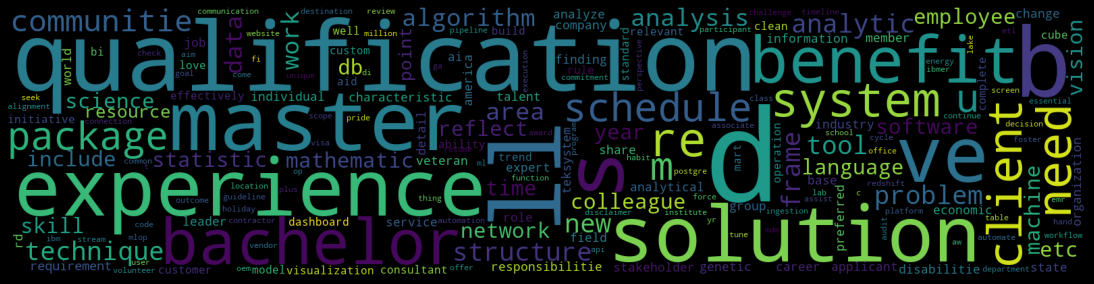

In [20]:
# WORDCLOUD from unfiltered data
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600,height=400).generate(" ".join(sqrt_desc_dict.keys()))
plt.figure(figsize=(15,10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();

In [21]:
# RELEVANT SKILLS for comparison against description terms
languages_list = ['python','r','sql','spark','hadoop','java','sas','hive','scala','c++','aws','angular','vue.js',
                  'tensorflow','matlab','c','excel','linux','nosql','azure','scikit-learn','spss','pandas',
                  'numpy','pig','d3','keras','javascript','c#','perl','hbase','docker','git','mysql','pyspark',
                  'mongodb','cassandra','pytorch','caffe','node.js','redshift','tableau', 'powerbi', 'power bi',
                  'alteryx','oracle','excel','apache','english','.net','jquery','ruby','postgres','julia','ibm',
                  'scipy','h2o','django','html','css','salesforce','mongo','scikit','node'] # last 3 are alternative names

hard_skills_list = ['data visualization','visualization','data cleaning','cleaning','data mining','mining',
                    'data modeling','modeling','data analysis','analysis','analytics',
                    'machine learning','ml','machine','deep','artificial intelligence','ai','intelligence',
                    'research','simulation','algorithms','automated','predictive','metrics','genetics',
                    'math','linear algebra', 'calculus','statistical analysis','masters','degree','phd',
                    'natural language','language','nlp','neural network','selenium','teradata','cloud',
                    'business intelligence','bi','sales','security','testing','frontend','backend']

soft_skills_list = ['critical thinking','thinking','communication','storytelling','presentation','management',
                    'strategy','process improvement','agile','networking','consulting','leadership']

def export_skills_to_csv(skills_counted):
    """ export skills and respective ranks to csv for future use """
    
    new_dict = {}
    for k, v in skills_counted.items():
        new_dict.update({k:v})
    print(new_dict)
    
    csv_columns = ['skill','frequency']
    csv_file = f'output/skills_ranked_{datetime.date.today()}.csv'
    
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        writer.writeheader()
        for data in new_dict:
            writer.writerow(data)
    
    #with open(f'output/skills_ranked_{datetime.date.today()}.csv', 'w', newline='') as skills_counted:
    #    csv_out = csv.writer(skills_counted)
    #    csv_out.writerows([skills_counted[index]] for index in range(0, len(skills_counted)))
    return

def parse_for_skills_aggregate(df, desc_list, languages_list, hard_skills_list, soft_skills_list):
    """ Takes in a dataframe and its tokenized terms in order to display an aggregate score for relevant languages and skills in all descriptions """
    # take frequency of all terms
    sqrt_desc_dict, deflated_desc_dict = analyze_overall_frequency(desc_list)
    
    # init new dicts for new columns 
    languages_unranked = {}
    hard_skills_unranked = {}
    soft_skills_unranked = {}    
    
    # add all relevant terms to new lists
    for k, v in sqrt_desc_dict.items():
        if k in languages_list:
            languages_unranked.update({k:v})
        elif k in hard_skills_list:
            hard_skills_unranked.update({k:v})
        elif k in soft_skills_list:
            soft_skills_unranked.update({k:v})
    
    # SORT lists
    languages_ranked = dict(sorted(languages_unranked.items(), key=lambda item: item[1]))
    hard_skills_ranked = dict(sorted(hard_skills_unranked.items(), key=lambda item: item[1]))
    soft_skills_ranked = dict(sorted(soft_skills_unranked.items(), key=lambda item: item[1]))
    
    # DEBUG
    print(f'Total weighted popularity of {len(languages_ranked)} lanugages:', '\n', languages_ranked, '\n')
    print(f'Total weighted popularity of {len(hard_skills_ranked)} hard skills:', '\n', hard_skills_ranked, '\n')
    print(f'Total weighted popularity of {len(soft_skills_ranked)} soft skills:', '\n', soft_skills_ranked, '\n')
    
    # EXPORT AGGREGATE SKILLS TO JSON
    with open('output/languages_ranked.json', 'w') as fp:
        json.dump(languages_ranked, fp)
    with open('output/hard_skills_ranked.json', 'w') as fp:
        json.dump(hard_skills_ranked, fp)
    with open('output/soft_skills_ranked.json', 'w') as fp:
        json.dump(soft_skills_ranked, fp)
        
    # EXPORT AGGREGATE SKILLS TO CSV # FIX: probably remove
    #languages_ranked_df = pd.DataFrame(languages_ranked)
    #df.to_csv(f'output/aggregate_languages_rank_{datetime.date.today()}.csv', index = False, encoding='utf-8')
    #hard_skills_ranked_df = pd.DataFrame(hard_skills_ranked)
    #df.to_csv(f'output/aggregate_hard_skills_rank_{datetime.date.today()}.csv', index = False, encoding='utf-8')
    #soft_skills_ranked_df = pd.DataFrame(soft_skills_ranked)
    #df.to_csv(f'output/aggregate_soft_skills_rank_{datetime.date.today()}.csv', index = False, encoding='utf-8')    
    
    return 

parse_for_skills_aggregate(df, df.description, languages_list, hard_skills_list, soft_skills_list)


Total weighted popularity of 49 lanugages: 
 {'django': 1.0, 'd3': 1.0, 'h2o': 1.0, 'mysql': 1.0, 'julia': 1.0, 'scikit': 3.0, 'pyspark': 3.41, 'numpy': 4.0, 'keras': 5.0, 'postgres': 5.0, 'ruby': 6.0, 'angular': 6.0, 'pytorch': 6.41, 'node': 7.0, 'tensorflow': 8.0, 'perl': 8.0, 'hbase': 9.0, 'css': 9.0, 'pig': 10.23, 'html': 12.41, 'matlab': 19.23, 'javascript': 19.41, 'spss': 24.82, 'cassandra': 26.23, 'english': 29.28, 'ibm': 30.34, 'apache': 39.33, 'linux': 39.64, 'mongo': 42.0, 'docker': 43.23, 'alteryx': 46.42999999999998, 'scala': 53.64, 'salesforce': 57.719999999999985, 'redshift': 67.69, 'hive': 76.32999999999998, 'sas': 81.00999999999998, 'git': 87.33999999999997, 'oracle': 118.88999999999997, 'hadoop': 131.34999999999997, 'java': 143.71999999999997, 'spark': 158.2899999999999, 'r': 171.39999999999992, 'aws': 176.5399999999999, 'c': 199.81999999999988, 'tableau': 221.31999999999994, 'excel': 221.77999999999992, 'azure': 242.70999999999987, 'python': 475.3900000000008, 'sql': 

### New Columns from Skills: Languages, Hardk Skills, and Soft Skills
The frequency list (and visual wordcloud) demonstrated a large range of useful skills as well as a lot of garbage data. Now we will parse through the list of tokenized descriptions to find all words matching data-analytics-related launguages, tools, hard skills and soft skills.

In [22]:
def parse_for_skills_newcol(df, desc_list, skill_list):
    """ Returns a list of values to be added to a new column in a dataframe, from a list of tokenized terms which are checked against a list of relevant skills """    
    # TOKENIZE DESCRIPTIONS (store into 2d array)
    clean_desc_list = tokenize(clean_text_basic(desc_list))

    # CONVERT DESCRIPTIONS to ROOTED LIST
    list_of_dicts = []
    for desc in clean_desc_list:
        sqrt_desc_dict = {} # save w sqrt, to give weight to skills mentioned more than once
        counted_desc = Counter(desc) # count frequency of description terms
        for k, v in counted_desc.items():
            if k in skill_list: # keep only terms matching skills list
                sqrt_desc_dict.update({k: float(format(math.sqrt(v), ".2f"))})
        list_of_dicts.append(sqrt_desc_dict)
    
    # add each index of the list (of term frequency dictionaries) to the same index of the dataframe
    #for idx, elem in list_of_dicts.items():
    #    df[]
    
    # add each description's filtered lists to the new columns
    #list_of_dicts = {}
    #for desc in clean_desc_list:
    #    temp_dict = {}
    #    for word in desc:
    #        if word in skill_list:
    #            temp = 2 # FIX: save frequency of word in description
    #            temp = sqrt() # FIX: sqrt of value
    #            list_of_dicts.update({temp}) # FIX
    #    # FIX: rank (order by value)
    #    # FIX: flip (bc rank seems to value lowest first)
    return list_of_dicts

# 3 new columns in dataframe: languages, hard skills, and soft skills
df.insert(3, 'languages', parse_for_skills_newcol(df, df.description, languages_list))
df.insert(4, 'hard_skills', parse_for_skills_newcol(df, df.description, hard_skills_list))
df.insert(5, 'soft_skills', parse_for_skills_newcol(df, df.description, soft_skills_list))
df

,role,title,company,languages,hard_skills,soft_skills,location,remote,contract_type,company_size,description,salary
0,Data Scientist,Data Scientist,Nordstrom,"{'sql': 1.41, 'r': 1.0, 'python': 1.0, 'hadoop...","{'research': 1.0, 'analysis': 1.41, 'modeling'...",{},"Seattle, WA",On-site,level,"10,001+ employees · Retail",About the job\n \n\n \nJob Descriptio...,Full-time · Entry
1,Data Scientist,"Data Scientist, Auction Expert",Meta,"{'python': 1.0, 'r': 1.0, 'matlab': 1.0, 'spss...","{'research': 2.0, 'masters': 1.0, 'deep': 1.41...","{'strategy': 2.0, 'consulting': 1.0}","Austin, TX",NaN,Full-time,"10,001+ employees · Technology, Information an...",About the job\n \n\n \n ...,NaN
2,Data Analyst,Junior Data Analyst,Allegis Group,"{'sql': 1.73, 'excel': 1.0}",{'analysis': 1.41},{},"Miami, FL",Hybrid,Associate,"10,001+ employees · Staffing and Recruiting",About the job\n \n\n \nSkills\n\nONE ...,Full-time
3,Data Analyst,Data Analyst REMOTE,"Software Guidance & Assistance, Inc. (SGA, Inc.)",{'python': 1.0},"{'mining': 1.41, 'degree': 1.0, 'analysis': 1.41}","{'presentation': 1.0, 'thinking': 1.0, 'strate...","Jacksonville, FL",Remote,level,201-500 employees · Staffing and Recruiting,About the job\n \n\n \nJob Descriptio...,Contract · Entry
4,Data Architect,Data Visualization Architect,American City Business Journals,"{'excel': 1.0, 'sql': 1.0, 'azure': 1.0}","{'visualization': 2.24, 'bi': 1.41, 'analysis'...","{'presentation': 1.0, 'management': 1.0, 'lead...","Charlotte, NC",Hybrid,Associate,"1,001-5,000 employees · Book and Periodical Pu...",About the job\n \n\n \n ...,Full-time
...,...,...,...,...,...,...,...,...,...,...,...,...
976,Data Engineer,Data Engineer,Pearson,"{'java': 1.0, 'python': 1.0, 'sql': 2.0, 'apac...",{'cloud': 1.73},"{'agile': 1.41, 'communication': 1.0, 'strateg...","Durham, NC",NaN,Full-time,"10,001+ employees · Education",About the job\n \n\n \n ...,Full-time
977,Data Analyst,Data Integrity Analyst - Remote,Kforce Inc,{'excel': 1.0},{'research': 1.0},{},"Boston, MA",Remote,Associate,"1,001-5,000 employees · Staffing and Recruiting",About the job\n \n\n \nResponsibiliti...,Contract
978,Data Scientist,DATA SCIENTIST III,Moffitt Cancer Center,"{'r': 1.0, 'python': 1.0, 'sql': 1.0, 'git': 1...","{'research': 1.41, 'visualization': 1.41, 'pre...","{'strategy': 1.73, 'communication': 1.0}","Tampa, FL",remote?,level,"5,001-10,000 employees · Hospitals and Health ...",About the job\n \n\n \n ...,Full-time · Entry
979,Data Analyst,Data Analyst II,RTD,{},"{'research': 1.41, 'modeling': 1.0, 'analysis'...","{'leadership': 1.0, 'presentation': 1.0}","Denver, CO",NaN,level,"1,001-5,000 employees · Truck Transportation",About the job\n \n\n \n ...,Full-time · Entry


In [23]:
def parse_for_skills_newdf(df, desc_list, langs, hards, softs):
    """ Returns a new dataframe, with new columns of necessary data skills from a list of tokenized terms which are checked against a list of relevant skills """    
        
    # TOKENIZE DESCRIPTIONS (store into 2d array)
    clean_desc_list = tokenize(clean_text_basic(desc_list))
    
    # new dict with all terms to search
    skill_dict = {}
    for elem in langs:
        skill_dict.update({elem:[]})
    for elem in hards:
        skill_dict.update({elem:[]})
    for elem in softs:
        skill_dict.update({elem:[]})
    #print(skill_dict)
    
    # CONVERT DESCRIPTIONS to ROOTED LIST
    counted_desc_list = []
    for desc in clean_desc_list:
        counted_desc = Counter(desc) # count frequency of description terms
        counted_desc_list.append(counted_desc)
    
    for skill in skill_dict: # check each skill
        for desc in counted_desc_list: # check each description
            if skill in desc: 
                skill_dict[skill].append(1) # add frequency of skill to the skill's list in dictionary
            else:
                skill_dict[skill].append(0)
    # print('length of Python in skills dictionary:',len(skill_dict['python'])) # DEBUG
    
    # create new df from dict of all skills by row
    df_skills = pd.DataFrame(skill_dict)

    # insert 4 columns from old df, only relevant data to compare against
    #df_skills.insert(0, 'location', df.location)
    #df_skills.insert(0, 'company', df.company)
    df_skills.insert(0, 'job', df.role)
    
    return df_skills

df_skills = parse_for_skills_newdf(df, df.description, languages_list, hard_skills_list, soft_skills_list)
df_skills

,job,python,r,sql,spark,hadoop,java,sas,hive,scala,...,communication,storytelling,presentation,management,strategy,process improvement,agile,networking,consulting,leadership
0,Data Scientist,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Data Scientist,1,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,Data Analyst,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Data Analyst,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,Data Architect,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
976,Data Engineer,1,0,1,1,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
977,Data Analyst,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
978,Data Scientist,1,1,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
979,Data Analyst,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


### BONUS: Emoji on LinkedIn
It seems that the most popular emoji used on LinkedIn is the trademark logo. No surprise there! But why not just use the ascii character?

In [ ]:
"""
# BONUS: MOST POPULAR EMOJI ON LINKEDIN
import emoji
emoji_unranked = {}
for k, v in deflated_desc_dict.items():
    if emoji.is_emoji(k):
        emoji_unranked.update({k:v})

emoji_ranked = dict(sorted(emoji_unranked.items(), key=lambda item: item[1]))
print(emoji_ranked)
"""

In [ ]:
"""
# WORDCLOUD from filtered emoji
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600,height=400).generate(" ".join(emoji_ranked.keys()))
plt.figure(figsize=(15,10), facecolor="k")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('images/wordcloud_emoji.png', facecolor='k', bbox_inches='tight')
plt.show();
"""

# Export Data to CSV for Visualization

In [26]:
df.to_csv(f'output/linkedin_jobs_cleaned_full_{datetime.date.today()}.csv', index = False, encoding='utf-8')
df_skills.to_csv(f'output/linkedin_skill_requirements_full_{datetime.date.today()}.csv', index = False, encoding='utf-8')